# Part (c) – Gaussian Mixture Models (GMM)

Steps:
1. Load dataset (default: Wine Quality).
2. Standardize numeric features.
3. Fit GMMs with different component counts and compare BIC.
4. Choose best model, compute silhouette score, and visualize.


Assignment done by :- Dev Mulchandani

In [2]:
# @title Load dataset (upload / URL / Kaggle)
import pandas as pd
import zipfile
from pathlib import Path

try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

DEFAULT_URL = "https://raw.githubusercontent.com/riorain/wine-quality-dataset/master/winequality-red.csv"  # You can change this to another CSV URL

print("How do you want to load the dataset?")
print("1 = upload CSV file manually")
print("2 = download from URL (uses DEFAULT_URL above)")
print("3 = download from Kaggle (you must provide kaggle.json & dataset name)")
choice = input("Enter 1, 2, or 3: ").strip()

if choice == "1":
    if not IN_COLAB:
        raise RuntimeError("Manual upload only works in Google Colab.")
    uploaded = files.upload()
    fname = list(uploaded.keys())[0]
    df = pd.read_csv(fname)
    print("Loaded:", fname, "shape:", df.shape)
elif choice == "2":
    if not DEFAULT_URL:
        raise ValueError("DEFAULT_URL is empty. Please set it to a valid CSV URL or choose another option.")
    df = pd.read_csv(DEFAULT_URL)
    print("Loaded from URL. Shape:", df.shape)
elif choice == "3":
    import os, subprocess

    if IN_COLAB:
        from google.colab import files  # type: ignore
        print("Please upload your kaggle.json file (from your Kaggle account).")
        uploaded = files.upload()
        kaggle_path = Path("~/.kaggle").expanduser()
        kaggle_path.mkdir(parents=True, exist_ok=True)
        for fn in uploaded:
            Path(fn).replace(kaggle_path / "kaggle.json")
        os.chmod(kaggle_path / "kaggle.json", 0o600)

    # Install kaggle CLI
    import sys
    !pip -q install kaggle

    DATASET_SLUG = input("Enter Kaggle dataset slug (e.g. 'uciml/iris'): ").strip()

    # Download entire dataset (may contain multiple files)
    !kaggle datasets download -d $DATASET_SLUG -p kaggle_data

    # Unzip everything
    kaggle_dir = Path("kaggle_data")
    kaggle_dir.mkdir(exist_ok=True)
    for zpath in kaggle_dir.glob("*.zip"):
        with zipfile.ZipFile(zpath, "r") as zf:
            zf.extractall(kaggle_dir)

    csv_files = list(kaggle_dir.rglob("*.csv"))
    if not csv_files:
        raise FileNotFoundError("No CSV files found in Kaggle dataset; please inspect kaggle_data/ manually.")
    csv_path = csv_files[0]
    print("Using CSV:", csv_path)
    df = pd.read_csv(csv_path)
    print("Loaded from Kaggle. Shape:", df.shape)
else:
    raise ValueError("Invalid choice. Please run this cell again.")

df.head()


How do you want to load the dataset?
1 = upload CSV file manually
2 = download from URL (uses DEFAULT_URL above)
3 = download from Kaggle (you must provide kaggle.json & dataset name)
Enter 1, 2, or 3: 1


Saving winequality.csv to winequality.csv
Loaded: winequality.csv shape: (200, 5)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,alcohol
0,8.170528,0.332532,0.605048,6.349688,13.079245
1,10.992366,1.434196,0.847980,1.100501,10.305749
2,9.162480,0.116799,0.457128,6.576316,10.000033
3,6.286952,1.418771,0.551276,7.615411,12.197512
4,5.963014,1.284253,0.741329,2.603784,12.374327


In [3]:
# @title Preprocess data
import numpy as np
from sklearn.preprocessing import StandardScaler

X = df.select_dtypes(include=["float64", "int64"]).values
print("Feature matrix shape:", X.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Feature matrix shape: (200, 5)


In [4]:
# @title Fit Gaussian Mixture models and select best BIC
from sklearn.mixture import GaussianMixture
import numpy as np

lowest_bic = np.inf
best_gmm = None
best_k = None
bics = []

for k in range(2, 8):
    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    gmm.fit(X_scaled)
    bic = gmm.bic(X_scaled)
    bics.append(bic)
    print(f"k={k}, BIC={bic:.2f}")
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm
        best_k = k

print("Best k according to BIC:", best_k)
labels = best_gmm.predict(X_scaled)


k=2, BIC=3029.47
k=3, BIC=3017.01
k=4, BIC=3117.27
k=5, BIC=3197.99
k=6, BIC=3248.42
k=7, BIC=3329.47
Best k according to BIC: 3


Silhouette score (k=3): 0.129


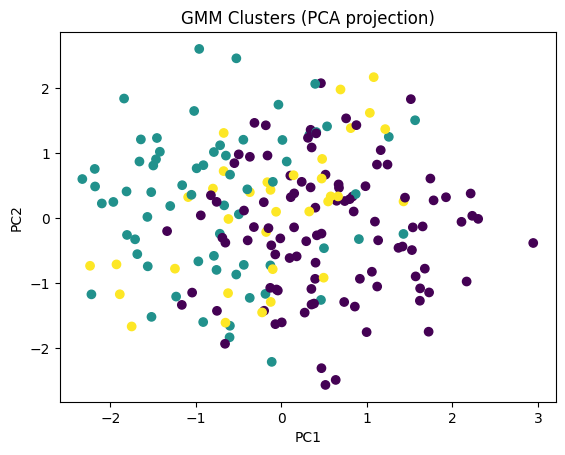

In [5]:
# @title Evaluate & visualize
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

score = silhouette_score(X_scaled, labels)
print(f"Silhouette score (k={best_k}): {score:.3f}")

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels)
plt.title("GMM Clusters (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
